In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [ ]:
import cv2
import zipfile
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

### Data Preparation and Understanding

In [ ]:
path = "/content/drive/MyDrive/CV/data/"
path_zip = "/content/drive/MyDrive/CV/data/Retinal Vessel.zip"

In [ ]:
if os.path.exists(path_zip):
    print(f"The zip file exists at: {path_zip}")
else:
    print(f"The zip file does not exist at: {path_zip}")

The zip file exists at: /content/drive/MyDrive/CV/data/Retinal Vessel.zip


In [ ]:
extract_dir = os.path.join(path, "extracted_retinal_vessel")
os.makedirs(extract_dir, exist_ok=True)
print(f"Extraction directory created at: {extract_dir}")

Extraction directory created at: /content/drive/MyDrive/CV/data/extracted_retinal_vessel


In [ ]:
with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
extracted_files = os.listdir(extract_dir)
print("Extracted files and directories:")
for item in extracted_files:
    print(item)

Extracted files and directories:
Retinal Vessel


Sau giải nén , thu được 2 dataset là: DRIVE và STARE
- DRIVE: chia thành 2 tập test và train. Tập test có thư mục 1st_manual, 2st_manual, mask, images. Tập train có 1st_manual, mask, images.
- STARE: có 3 thư mục con: pngdata, pnglabel_ah, pnglabel_vk.

#### DRIVE Dataset

In [ ]:
path1 = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE"

In [ ]:
if os.path.exists(path1):
    print(f"The path {path1} exists.")
    print("Contents of the directory:")
    for root, dirs, files in os.walk(path1):
        level = root.replace(path1, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')
else:
    print(f"The path {path1} does not exist.")

The path /content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE exists.
Contents of the directory:
DRIVE/
    test/
        1st_manual/
            01_manual1.gif
            02_manual1.gif
            03_manual1.gif
            04_manual1.gif
            05_manual1.gif
            06_manual1.gif
            07_manual1.gif
            08_manual1.gif
            09_manual1.gif
            10_manual1.gif
            11_manual1.gif
            12_manual1.gif
            13_manual1.gif
            14_manual1.gif
            15_manual1.gif
            16_manual1.gif
            17_manual1.gif
            18_manual1.gif
            19_manual1.gif
            20_manual1.gif
        2nd_manual/
            01_manual2.gif
            02_manual2.gif
            03_manual2.gif
            04_manual2.gif
            05_manual2.gif
            06_manual2.gif
            07_manual2.gif
            08_manual2.gif
            09_manual2.gif
            10_manual2.gif
            

DRIVE có tập train và test. Tập test chứa 20 ảnh đầu, và tập train chứa 20 ảnh sau để huấn luyện. Mỗi ảnh chứa 3 file liên quan:
- ảnh gốc fundus
- ảnh mask vùng có võng mạc
- ảnh nhãn ground truth segmentation - mạch máu được tô trắng

Cụ thể:
- images/ file.tif là ảnh gốc của võng mạc
- 1st_manual/ file.gif là ground truth segmentation được gắn thủ công bởi chuyên gia thứ 1
- 2nd_manual/ file.gif là ground truth segmentation gắn bởi expert 2
- mask/ file.gif là vùng quan tâm ROI - region of interest của võng mạc



Kích thước: (584, 565, 3) Kiểu dữ liệu: uint8


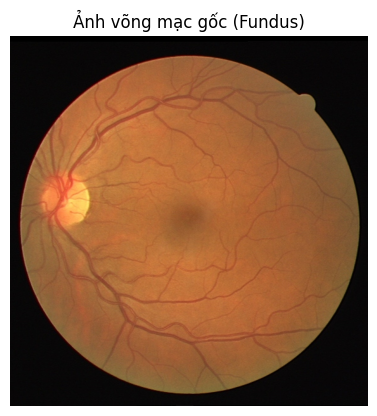

In [ ]:
image_path = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE/test/images/01_test.tif"
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
print("Kích thước:", img_rgb.shape, "Kiểu dữ liệu:", img_rgb.dtype)
# Kích thước: (h,w,c) = (584, 565, 3) Kiểu dữ liệu: uint8
plt.imshow(img_rgb)
plt.title("Ảnh võng mạc gốc (Fundus)")
plt.axis('off')
plt.show()

Ảnh gốc - ảnh fundus từ bộ DRIVE có kích thước w = 565 × h = 584 pixel, 3 kênh màu (RGB) và độ sâu bit 8-bit.

Kích thước: (584, 565) Kiểu dữ liệu: uint8
Giá trị duy nhất: [  0 255]


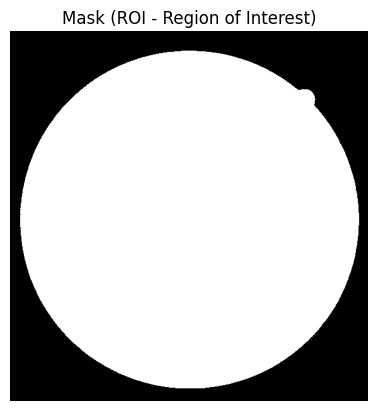

In [ ]:
mask_path = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE/test/mask/01_test_mask.gif"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
print("Kích thước:", mask.shape, "Kiểu dữ liệu:", mask.dtype) # Kích thước: (584, 565) Kiểu dữ liệu: uint8

print("Giá trị duy nhất:", np.unique(mask))

plt.imshow(mask, cmap='gray')
plt.title("Mask (ROI - Region of Interest)")
plt.axis('off')
plt.show()

Ảnh mark là ảnh nhị phân có cùng kích thước với ảnh fundus. Mỗi px của mask có giá trị 0 đến 255. Trong đó:
- 255: màu trắng biểu diễn vùng võng mạc cần phân tích
- 0: màu đen biểu diễn vùng nền bên ngoài, không chứa thông tin y khoa

-> Trong tiền xử lý, dùng mask này nhân với ảnh fundus để giữ lại vùng ROI

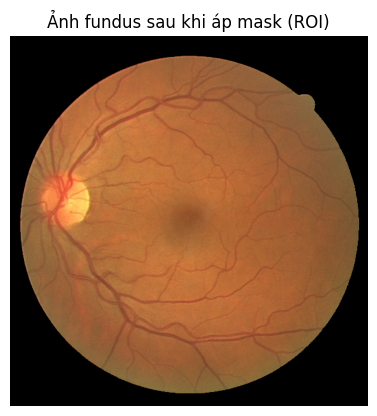

In [ ]:
fundus_masked_test = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

plt.imshow(fundus_masked_test)
plt.title("Ảnh fundus sau khi áp mask (ROI)")
plt.axis('off')
plt.show()

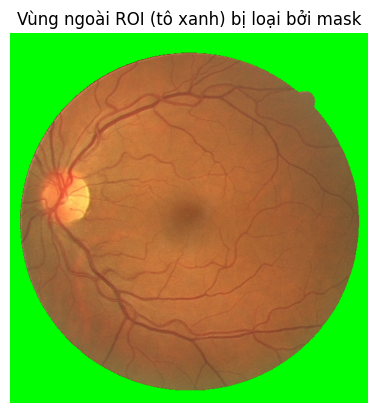

In [ ]:
# kiểm chứng hoạt động của việc áp mask vào ảnh fundus
# NX: ảnh fundus sau khi áp mask trông gần giống ảnh gốc vì nền xung quanh
# võng mạc vốn gần như đen hoàn toàn, nên việc áp mask đảm bảo chỉ các px
# thuộc vùng võng mạc - ROI được giữ lại, giúp model học đặc trưng chính
# xác và tránh nhiễu ở vùng biên
overlay = img_rgb.copy()
overlay[mask == 0] = [0, 255, 0]  # tô màu xanh vùng bị loại bỏ

plt.imshow(overlay)
plt.title("Vùng ngoài ROI (tô xanh) bị loại bởi mask")
plt.axis('off')
plt.show()

Kích thước: (584, 565) Kiểu dữ liệu: uint8
Giá trị duy nhất: [  0 255]


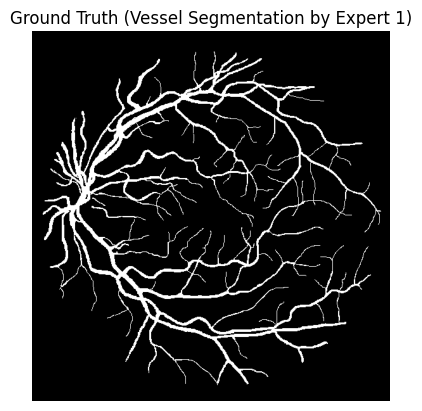

In [ ]:
ground_truth_1 = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE/test/1st_manual/01_manual1.gif"

gt1 = cv2.imread(ground_truth_1, cv2.IMREAD_GRAYSCALE)
print("Kích thước:", gt1.shape, "Kiểu dữ liệu:", gt1.dtype) # Kích thước: (584, 565) Kiểu dữ liệu: uint8
print("Giá trị duy nhất:", np.unique(gt1))

plt.imshow(gt1, cmap='gray')
plt.title("Ground Truth (Vessel Segmentation by Expert 1)")
plt.axis('off')
plt.show()

Kích thước: (584, 565) Kiểu dữ liệu: uint8
Giá trị duy nhất: [  3 253]


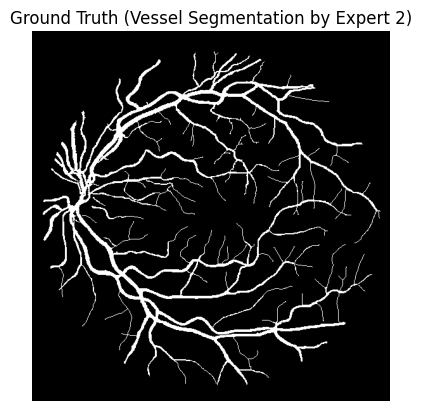

In [ ]:
ground_truth_2 = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE/test/2nd_manual/01_manual2.gif"
gt2 = cv2.imread(ground_truth_2, cv2.IMREAD_GRAYSCALE)
print("Kích thước:", gt2.shape, "Kiểu dữ liệu:", gt2.dtype) # Kích thước: (584, 565) Kiểu dữ liệu: uint8
print("Giá trị duy nhất:", np.unique(gt2))

plt.imshow(gt2, cmap='gray')
plt.title("Ground Truth (Vessel Segmentation by Expert 2)")
plt.axis('off')
plt.show()

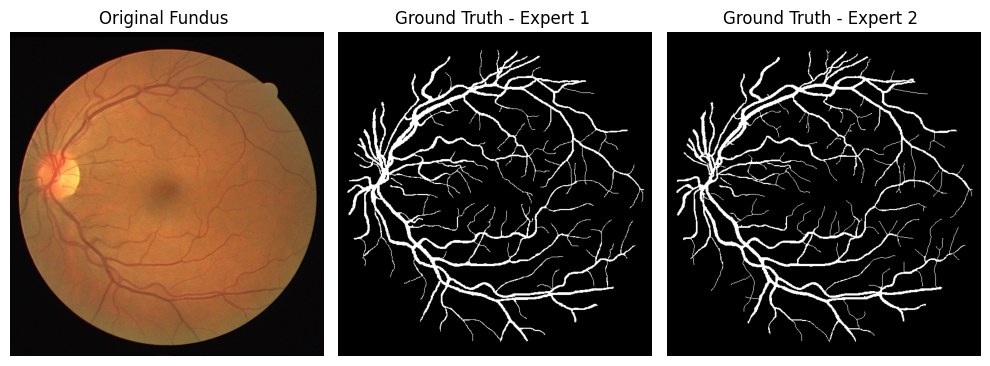

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))

axs[0].imshow(img_rgb)
axs[0].set_title("Original Fundus ")

axs[1].imshow(gt1, cmap='gray')
axs[1].set_title("Ground Truth - Expert 1 ")

axs[2].imshow(gt2, cmap='gray')
axs[2].set_title("Ground Truth - Expert 2 ")

for ax in axs: ax.axis("off")
plt.tight_layout()
plt.show()

Ground truth từ expert 1: đường mạch dày, liền mạch, bao phủ gần toàn bộ mạng lưới chính và phụ. Hầu như không bỏ sót nhánh nhỏ.

Ground truth từ expert 2: đường mạch mảnh hơn, nhiều nhánh nhỏ bị thiếu hoặc đứt đoạn.

#### STARE Dataset


In [ ]:
path2 = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/STARE"

In [ ]:
if os.path.exists(path2):
    print(f"The path {path2} exists.")
    print("Contents of the directory:")
    for root, dirs, files in os.walk(path2):
        level = root.replace(path2, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')
else:
    print(f"The path {path2} does not exist.")

The path /content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/STARE exists.
Contents of the directory:
STARE/
    pngdata/
        im0001.png
        im0002.png
        im0003.png
        im0004.png
        im0005.png
        im0044.png
        im0077.png
        im0081.png
        im0082.png
        im0139.png
        im0162.png
        im0163.png
        im0235.png
        im0236.png
        im0239.png
        im0240.png
        im0255.png
        im0291.png
        im0319.png
        im0324.png
    pnglabel_ah/
        im0001.png
        im0001_2ndHO.png
        im0002.png
        im0002_2ndHO.png
        im0003.png
        im0003_2ndHO.png
        im0004.png
        im0004_2ndHO.png
        im0005.png
        im0005_2ndHO.png
        im0044.png
        im0044_2ndHO.png
        im0077.png
        im0077_2ndHO.png
        im0081.png
        im0081_2ndHO.png
        im0082.png
        im0082_2ndHO.png
        im0139.png
        im0139_2ndHO.png
        im0162.png
   

STARE gồm 3 thư mục con:
- pngdata: ảnh gốc võng mạc - 20 ảnh, mỗi ảnh được gắn nhãn bởi 2 expert  
- pnglabel_ah: gt từ expert 2 -> sd để so sánh mô hình với người
- pnglabel_vk: gt từ expert 1 -> sd cho training và testing

Kích thước: (605, 700, 3) Kiểu dữ liệu: uint8


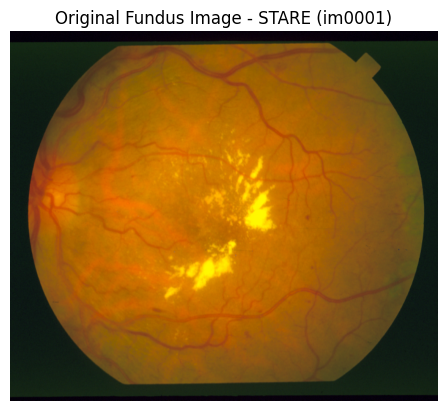

In [ ]:
fundus_stare = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/STARE/pngdata/im0001.png"
img = cv2.imread(fundus_stare)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Kích thước:", img_rgb.shape, "Kiểu dữ liệu:", img_rgb.dtype) # Kích thước: (605, 700) Kiểu dữ liệu: uint8

plt.imshow(img_rgb)
plt.title("Original Fundus Image - STARE (im0001)")
plt.axis("off")
plt.show()

Kích thước: (605, 700) Kiểu dữ liệu: uint8
Kích thước: (605, 700) Kiểu dữ liệu: uint8


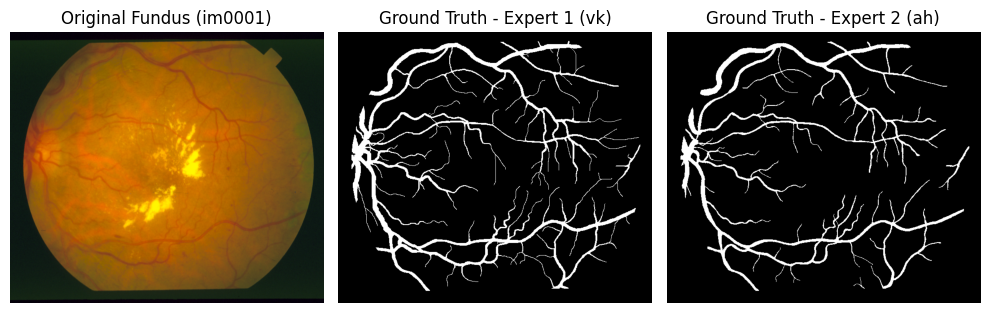

In [ ]:
label_ah = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/STARE/pnglabel_ah/im0001.png"
label_vk = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/STARE/pnglabel_vk/im0001.png"

mask_vk = cv2.imread(label_vk, cv2.IMREAD_GRAYSCALE)
mask_ah = cv2.imread(label_ah, cv2.IMREAD_GRAYSCALE)
print("Kích thước:", mask_vk.shape, "Kiểu dữ liệu:", mask_vk.dtype) # Kích thước: (605, 700) Kiểu dữ liệu: uint8
print("Kích thước:", mask_ah.shape, "Kiểu dữ liệu:", mask_ah.dtype) # Kích thước: (605, 700) Kiểu dữ liệu: uint8

fig, axs = plt.subplots(1, 3, figsize=(10,5))

axs[0].imshow(img_rgb)
axs[0].set_title("Original Fundus (im0001)")

axs[1].imshow(mask_vk, cmap='gray')
axs[1].set_title("Ground Truth - Expert 1 (vk)")

axs[2].imshow(mask_ah, cmap='gray')
axs[2].set_title("Ground Truth - Expert 2 (ah)")

for ax in axs: ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# trong thư mục có ảnh ground truth từ chuyên gia, nhưng có tới 2 ảnh cho 1 ảnh gắn nhãn
# cần kiểm tra sự khác biệt

# kiểm tra bằng cách so sánh giá trị px
binary_mask = cv2.imread("/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/STARE/pnglabel_vk/im0001.png", cv2.IMREAD_GRAYSCALE)
raw_label   = cv2.imread("/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/STARE/pnglabel_vk/im0001_1stHO.png", cv2.IMREAD_GRAYSCALE)

print("Binary mask unique values:", np.unique(binary_mask))
print("Raw 1stHO unique values:", np.unique(raw_label))

diff = cv2.absdiff(binary_mask, raw_label)
num_diff = np.count_nonzero(diff)
print("Số pixel khác nhau:", num_diff)
if num_diff == 0:
    print("Hai file hoàn toàn giống nhau (giá trị pixel trùng 100%)")
else:
    print("Có khác biệt nhỏ, kiểm tra thêm bằng hiển thị trực quan.")

Binary mask unique values: [  0 255]
Raw 1stHO unique values: [  0 255]
Số pixel khác nhau: 0
Hai file hoàn toàn giống nhau (giá trị pixel trùng 100%)


Tổng pixel trắng (binary): 9988605
Tổng pixel trắng (raw): 9988605


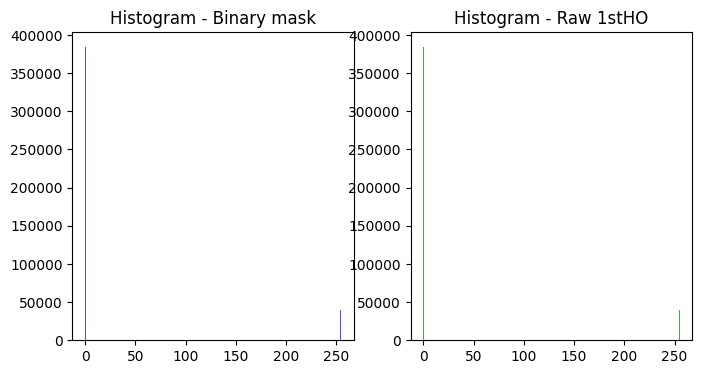

In [ ]:
# kiểm tra bằng cách so sánh thống kê: tổng, trung bình, độ lệch chuẩn & histogram
sum_bin = np.sum(binary_mask)
sum_raw = np.sum(raw_label)

print("Tổng pixel trắng (binary):", sum_bin)
print("Tổng pixel trắng (raw):", sum_raw)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(binary_mask.ravel(), bins=256, color='blue', alpha=0.7)
plt.title("Histogram - Binary mask")

plt.subplot(1,2,2)
plt.hist(raw_label.ravel(), bins=256, color='green', alpha=0.7)
plt.title("Histogram - Raw 1stHO")
plt.show()

Expert 1: vẽ chi tiết, đầy đủ mạch nhỏ, mạch liền, dày, bao quát hơn

Expert 2: mạch mảnh hơn, nhiều nhánh bị bỏ sót.

NX tổng thể 2 dataset:
- Ground truth từ expert 1 được dùng trong training và testing. Còn ground truth từ expert 2 sử dụng để tính toán hiệu suấ của con người.

- STARE xử lý khó hơn so với DRIVE vì một số ảnh bệnh lý bị giảm độ sắc nét và có bao gồm các bệnh lý.


### Simple EDA

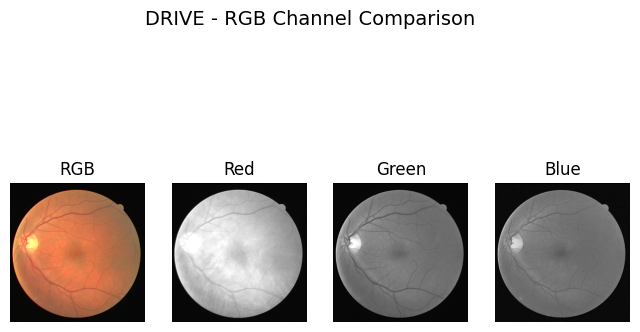

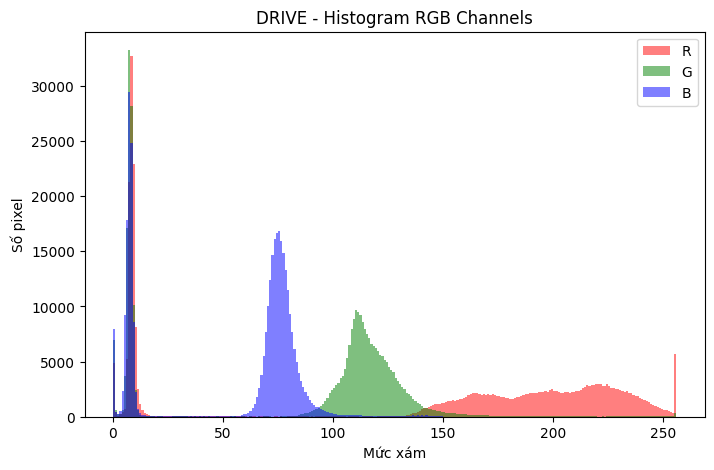

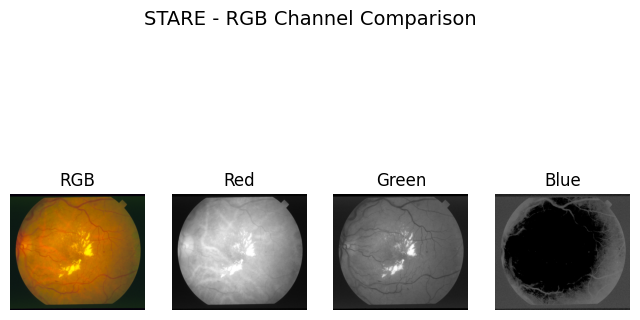

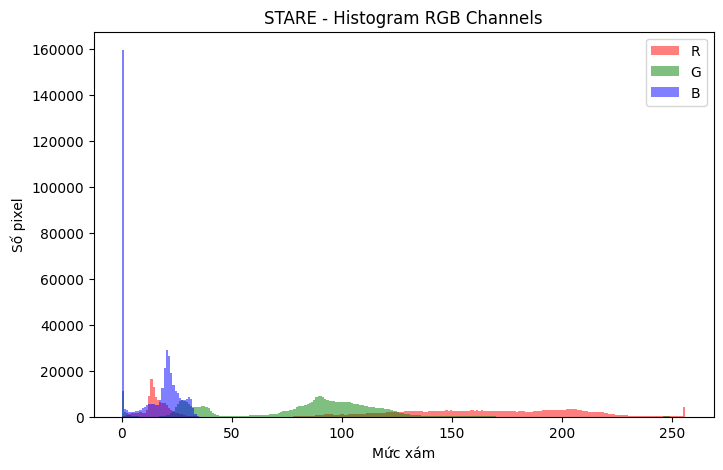

In [ ]:
def compare_rgb_channels(img_path, title_prefix=""):
    # Đọc ảnh RGB
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(img_rgb)

    # Hiển thị các kênh
    plt.figure(figsize=(8, 5))
    plt.suptitle(f"{title_prefix} - RGB Channel Comparison", fontsize=14)

    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title("RGB")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(r, cmap='gray')
    plt.title("Red")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(g, cmap='gray')
    plt.title("Green")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(b, cmap='gray')
    plt.title("Blue")
    plt.axis('off')

    plt.show()

    # Histogram
    plt.figure(figsize=(8,5))
    plt.hist(r.ravel(), bins=256, range=[0,256], color='red', alpha=0.5, label='R')
    plt.hist(g.ravel(), bins=256, range=[0,256], color='green', alpha=0.5, label='G')
    plt.hist(b.ravel(), bins=256, range=[0,256], color='blue', alpha=0.5, label='B')

    plt.title(f"{title_prefix} - Histogram RGB Channels")
    plt.xlabel("Mức xám")
    plt.ylabel("Số pixel")
    plt.legend()
    plt.show()

drive_img = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE/training/images/21_training.tif"
stare_img = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/STARE/pngdata/im0001.png"

compare_rgb_channels(drive_img, title_prefix="DRIVE")
compare_rgb_channels(stare_img, title_prefix="STARE")

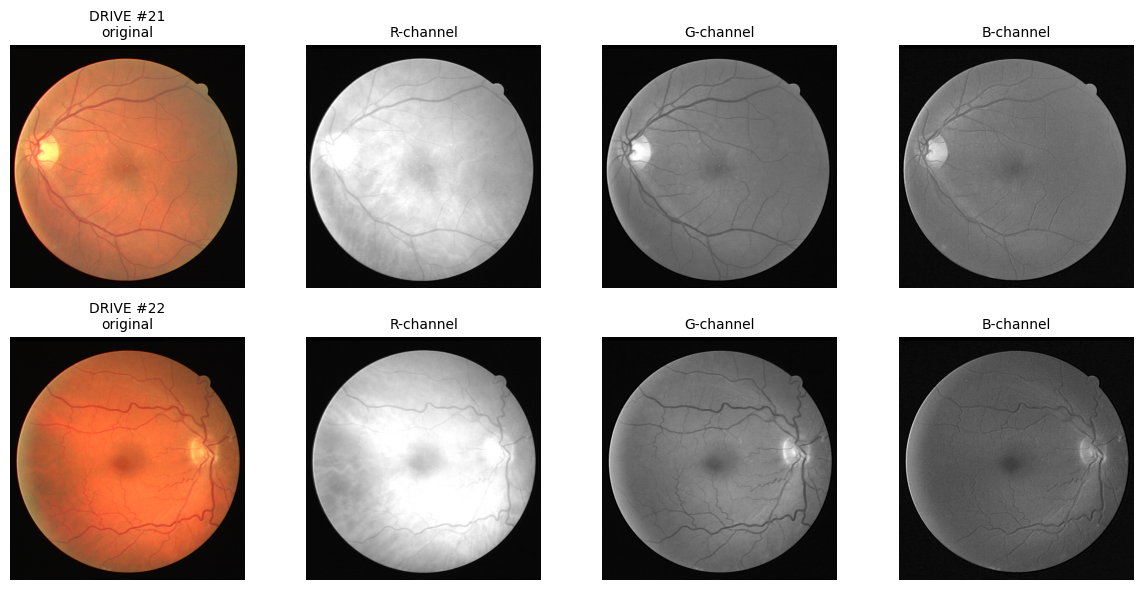

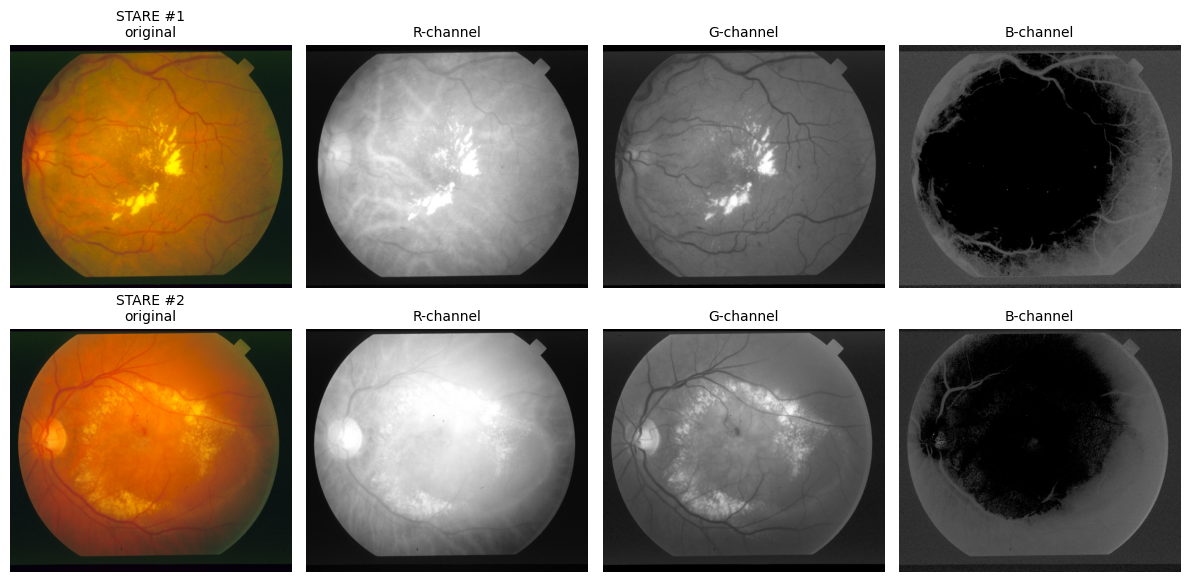

In [ ]:
def compare_rgb_channels_batch(image_paths, titles=None, n_cols=4):
    """
    Hiển thị nhiều ảnh fundus theo batch, mỗi hàng gồm (original, R, G, B)
    """
    n_imgs = len(image_paths)
    plt.figure(figsize=(n_cols * 3, n_imgs * 3))

    for idx, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        r, g, b = cv2.split(img_rgb)

        title_prefix = titles[idx] if titles and idx < len(titles) else os.path.basename(img_path)

        # original
        plt.subplot(n_imgs, n_cols, idx * n_cols + 1)
        plt.imshow(img_rgb)
        plt.title(f"{title_prefix}\noriginal", fontsize=10)
        plt.axis('off')

        # R channel
        plt.subplot(n_imgs, n_cols, idx * n_cols + 2)
        plt.imshow(r, cmap='gray')
        plt.title("R-channel", fontsize=10)
        plt.axis('off')

        # G channel
        plt.subplot(n_imgs, n_cols, idx * n_cols + 3)
        plt.imshow(g, cmap='gray')
        plt.title("G-channel", fontsize=10)
        plt.axis('off')

        # B channel
        plt.subplot(n_imgs, n_cols, idx * n_cols + 4)
        plt.imshow(b, cmap='gray')
        plt.title("B-channel", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# === Ví dụ sử dụng ===
drive_imgs = [
    "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE/training/images/21_training.tif",
    "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE/training/images/22_training.tif",
]

stare_imgs = [
    "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/STARE/pngdata/im0001.png",
    "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/STARE/pngdata/im0002.png",
]

compare_rgb_channels_batch(drive_imgs, titles=["DRIVE #21", "DRIVE #22"])
compare_rgb_channels_batch(stare_imgs, titles=["STARE #1", "STARE #2"])

NX:
- Cả 2 dataset đều cho thấy kênh Green luôn thể hiện độ tương phản cao nhất giữa mạch máu và nền võng mạc.
- Thông qua Histogram, STARE có biến động độ sáng lớn, nên cần các kỹ thuật tiền xử lý như: CLAHE (Contrast-Limited Adaptive Histogram Equalization) và Top-Hat Transform/Multi-scale Top-Hat Transform để chuẩn hóa và làm nổi bật mạch máu nhỏ trước khi trích xuất đặc trưng. Còn DRIVE có ánh sáng đồng đều và ít nhiễu thì cần tăng cường tương phản bằng CLAHE nhẹ.



#### Test MTHT trên ảnh xám dữ liệu DRIVE

In [ ]:
from skimage.measure import shannon_entropy

def modified_tophat_transform(image, G_size, Gp_size):
    """Modified White & Black Top-hat"""
    G  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (G_size, G_size))
    Gp = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (Gp_size, Gp_size))

    MWTH = image - cv2.dilate(cv2.erode(image, G), Gp)
    MBTH = cv2.erode(cv2.dilate(image, G), Gp) - image
    return MWTH, MBTH

def multiscale_tophat_entropy(image, mask=None, n=6, w=0.35, G0=3, Gp0=13):
    I = image.astype(np.float32)
    if mask is None:
      mask = np.ones_like(image, np.uint8)  # fallback mask toàn ảnh
    MB, MD = [], []

    # compute top-hat features for each scale
    for i in range(1, n+1):
        G_size  = G0  + 2*(i-1)
        Gp_size = Gp0 + 2*(i-1)
        mw, mb = modified_tophat_transform(I, G_size, Gp_size)
        MB.append(mw)
        MD.append(mb)

    # Subtractions of neighboring scales
    SNBS = [MB[i] - MB[i-1] for i in range(1, n)]
    SNDS = [MD[i] - MD[i-1] for i in range(1, n)]
    SMB   = np.sum(MB, axis=0)
    SMD   = np.sum(MD, axis=0)
    SSNBS = np.sum(SNBS, axis=0)
    SSNDS = np.sum(SNDS, axis=0)

    # Enhancement
    IE = I + w*(SMB + SSNBS) - w*(SMD + SSNDS)
    IE = np.clip(IE, 0, 255).astype(np.uint8)

    IE = cv2.bitwise_and(IE, IE, mask=mask)
    return IE

Entropy before: 5.727, after: 6.698


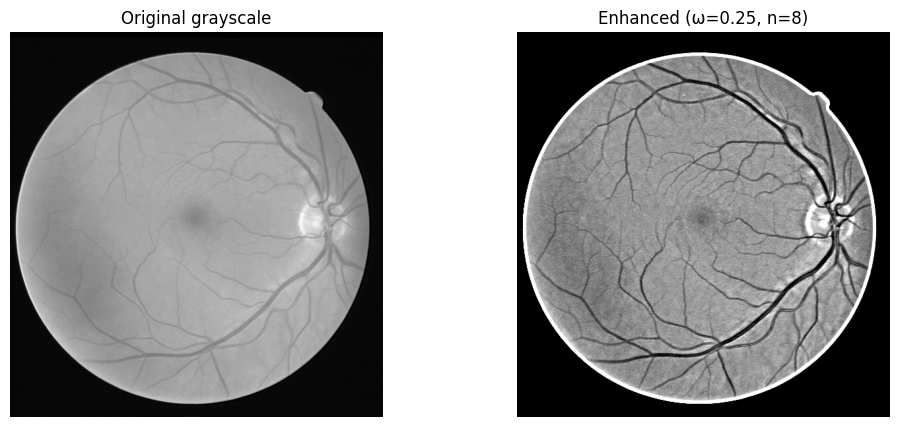

In [ ]:
image_path = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE/training/images/24_training.tif"
mask_path  = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE/training/mask/24_training_mask.gif"

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    print("No mask found — using full image area.")
    mask = np.ones_like(img, np.uint8)
else:
    mask = (mask > 0).astype(np.uint8)

enhanced = multiscale_tophat_entropy(img, mask, n=8, w=0.25, G0=3, Gp0=13)

orig_entropy = shannon_entropy(img[mask>0])
enh_entropy  = shannon_entropy(enhanced[mask>0])
print(f"Entropy before: {orig_entropy:.3f}, after: {enh_entropy:.3f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title("Original grayscale")
plt.axis('off')
plt.subplot(1,2,2); plt.imshow(enhanced, cmap='gray'); plt.title(f"Enhanced (ω=0.25, n=8)")
plt.axis('off')
plt.show()

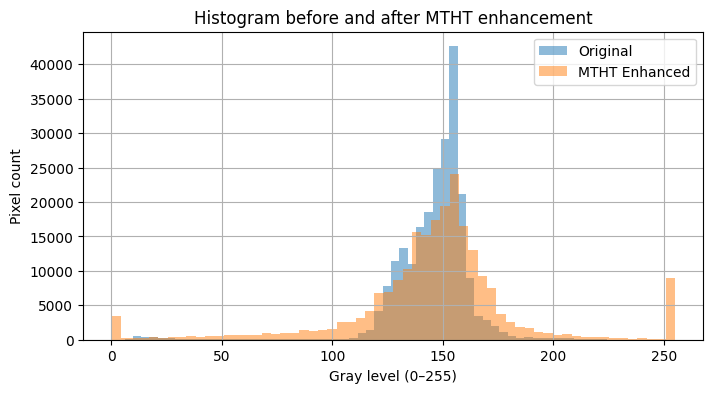

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(img[mask>0].ravel(), bins=60, alpha=0.5, label="Original")
plt.hist(enhanced[mask>0].ravel(), bins=60, alpha=0.5, label="MTHT Enhanced")
plt.xlabel("Gray level (0–255)")
plt.ylabel("Pixel count")
plt.title("Histogram before and after MTHT enhancement")
plt.legend(); plt.grid(True); plt.show()

In [ ]:
from skimage.measure import shannon_entropy

def metrics(image, mask=None):
    """Tính entropy và standard deviation trong vùng FOV (nếu có mask)."""
    img = image.astype(np.float32)
    if mask is None:
        mask = np.ones_like(img, np.uint8)
    fov = img[mask > 0]
    H = shannon_entropy(fov)
    std = np.std(fov)
    return H, std

def mean_gradient_metric(image, mask=None):
    """Tính mean gradient magnitude trong vùng FOV (nếu có mask)."""
    img = image.astype(np.float32)
    grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    if mask is None:
        return np.mean(grad_mag)
    else:
        return np.mean(grad_mag[mask > 0])

H_in, std_in = metrics(img, mask)
H_out, std_out = metrics(enhanced, mask)
CII = std_out / std_in if std_in > 1e-6 else np.nan
EII = H_out / H_in if H_in > 1e-6 else np.nan

In [ ]:
print("Evaluation Metrics for image from DRIVE")
grad_in  = mean_gradient_metric(img, mask)
grad_out = mean_gradient_metric(enhanced, mask)
print(f"Mean Gradient: {grad_in:.3f} → {grad_out:.3f}")
print(f"Entropy  (H): {H_in:.3f} → {H_out:.3f}  (EII={EII:.3f})")
print(f"Std Dev  (σ): {std_in:.3f} → {std_out:.3f}  (CII={CII:.3f})")
print(f"Mean Gradient: {grad_in:.3f} → {grad_out:.3f}")

Evaluation Metrics for image from DRIVE
Mean Gradient: 25.184 → 98.351
Entropy  (H): 5.727 → 6.694  (EII=1.169)
Std Dev  (σ): 18.932 → 41.788  (CII=2.207)
Mean Gradient: 25.184 → 98.351


#### Test MTHT trên ảnh xám dữ liệu STARE

No mask found — using full image area.
Entropy before: 6.767, after: 7.110


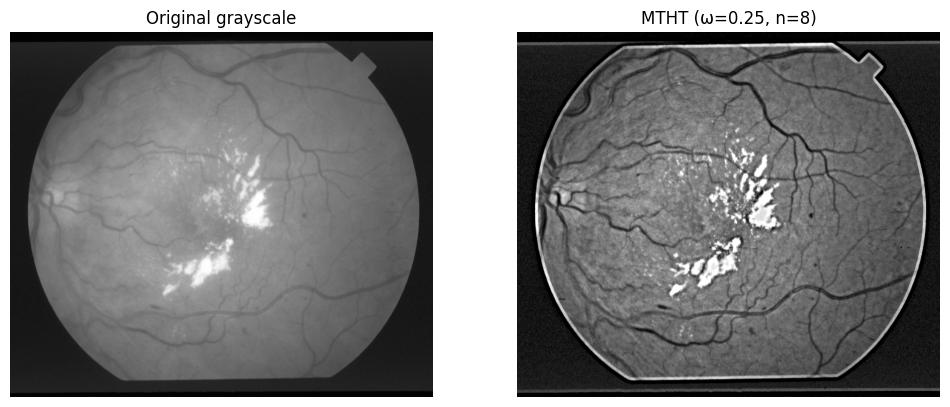

In [ ]:
from skimage.measure import shannon_entropy

image_path = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/STARE/pngdata/im0001.png"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Handle mask
mask = None  # STARE không có mask
if mask is None:
    print("No mask found — using full image area.")
    mask = np.ones_like(img, np.uint8)
else:
    mask = (mask > 0).astype(np.uint8)

# Apply MTHT
enhanced = multiscale_tophat_entropy(img, mask, n=8, w=0.25, G0=3, Gp0=13)

# Evaluate
orig_entropy = shannon_entropy(img[mask > 0])
enh_entropy  = shannon_entropy(enhanced[mask > 0])
print(f"Entropy before: {orig_entropy:.3f}, after: {enh_entropy:.3f}")

# Visualization
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original grayscale")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(enhanced, cmap='gray')
plt.title("MTHT (ω=0.25, n=8)")
plt.axis('off')
plt.show()

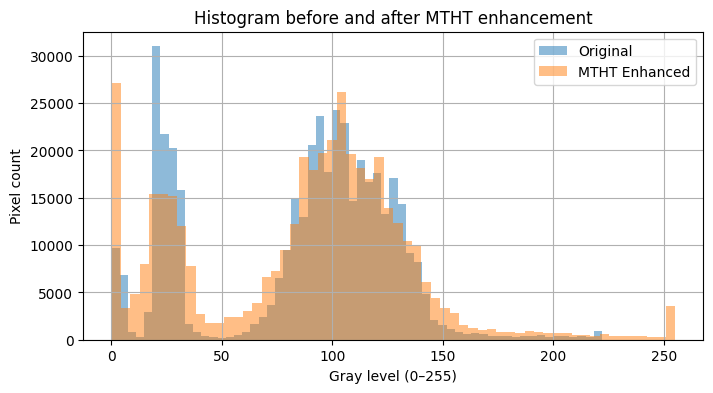

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(img[mask>0].ravel(), bins=60, alpha=0.5, label="Original")
plt.hist(enhanced[mask>0].ravel(), bins=60, alpha=0.5, label="MTHT Enhanced")
plt.xlabel("Gray level (0–255)")
plt.ylabel("Pixel count")
plt.title("Histogram before and after MTHT enhancement")
plt.legend(); plt.grid(True); plt.show()

In [ ]:
print("Evaluation Metrics for image from STARE")
grad_in  = mean_gradient_metric(img, mask)
grad_out = mean_gradient_metric(enhanced, mask)
print(f"Mean Gradient: {grad_in:.3f} → {grad_out:.3f}")
print(f"Entropy  (H): {H_in:.3f} → {H_out:.3f}  (EII={EII:.3f})")
print(f"Std Dev  (σ): {std_in:.3f} → {std_out:.3f}  (CII={CII:.3f})")
print(f"Mean Gradient: {grad_in:.3f} → {grad_out:.3f}")

Evaluation Metrics for image from STARE
Mean Gradient: 13.726 → 64.480
Entropy  (H): 5.727 → 6.694  (EII=1.169)
Std Dev  (σ): 18.932 → 41.788  (CII=2.207)
Mean Gradient: 13.726 → 64.480


#### Test pipeline tiền xử lý

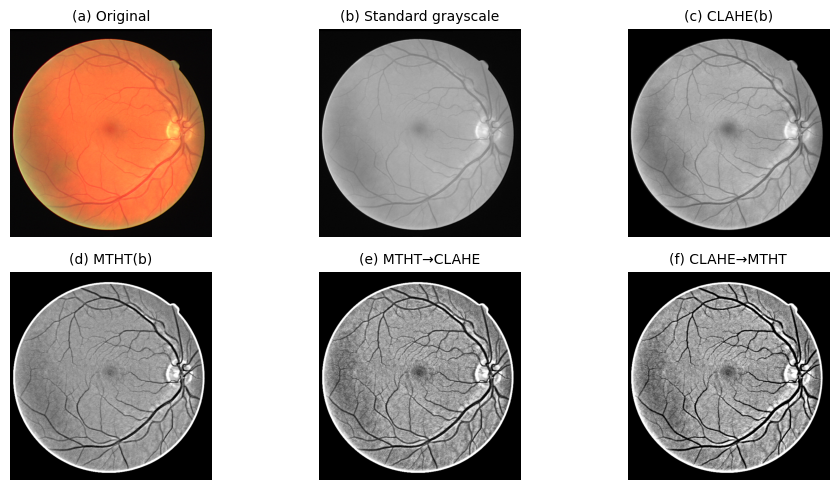

[Standard grayscale] Entropy before: 5.727 → after MTHT→CLAHE: 7.277


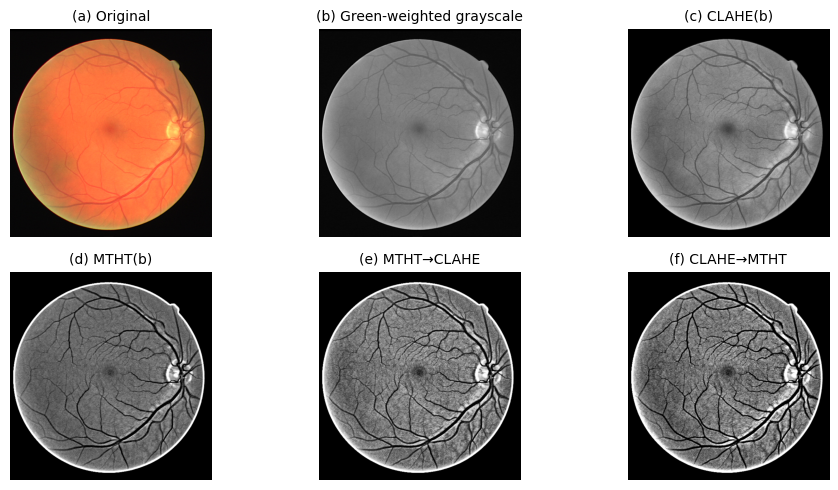

[Green-weighted grayscale] Entropy before: 5.656 → after MTHT→CLAHE: 7.311


In [ ]:
def rgb2gray_single(rgb):
    """Chuyển ảnh RGB sang grayscale nhấn mạnh kênh Green"""
    assert rgb.ndim == 3 and rgb.shape[2] == 3, "Ảnh đầu vào phải là RGB"
    r, g, b = cv2.split(rgb)
    gray = 0.75 * g + 0.25 * b
    return np.clip(gray, 0, 255).astype(np.uint8)

def apply_CLAHE(image, clip_limit=1.5, tile_grid_size=(8, 8)):
    """Tăng tương phản cục bộ bằng CLAHE"""
    if image.dtype != np.uint8:
        image = np.clip(image, 0, 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def modified_tophat_transform(image, G_size, Gp_size):
    """Modified White & Black Top-hat"""
    G  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (G_size, G_size))
    Gp = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (Gp_size, Gp_size))

    MWTH = image - cv2.dilate(cv2.erode(image, G), Gp)
    MBTH = cv2.erode(cv2.dilate(image, G), Gp) - image
    return MWTH, MBTH

def multiscale_tophat_entropy(image, mask=None, n=8, w=0.25, G0=3, Gp0=13):
    """Multi-scale Top-hat theo Entropy 2019"""
    I = image.astype(np.float32)
    if mask is None:
        mask = np.ones_like(image, np.uint8)

    MB, MD = [], []
    for i in range(1, n+1):
        G_size = G0 + 2*(i-1)
        Gp_size = Gp0 + 2*(i-1)
        mw, mb = modified_tophat_transform(I, G_size, Gp_size)
        MB.append(mw)
        MD.append(mb)

    SNBS = [MB[i] - MB[i-1] for i in range(1, n)]
    SNDS = [MD[i] - MD[i-1] for i in range(1, n)]
    SMB = np.sum(MB, axis=0)
    SMD = np.sum(MD, axis=0)
    SSNBS = np.sum(SNBS, axis=0)
    SSNDS = np.sum(SNDS, axis=0)

    IE = I + w*(SMB + SSNBS) - w*(SMD + SSNDS)
    IE = np.clip(IE, 0, 255).astype(np.uint8)
    IE = cv2.bitwise_and(IE, IE, mask=mask)
    return IE

def visualize_sinenet_preprocessing(image_path, mask_path=None, use_green_gray=False):
    """Minh họa pipeline tiền xử lý theo Sine-Net"""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # chọn loại grayscale
    if use_green_gray:
        gray = rgb2gray_single(img_rgb)
        gray_type = "Green-weighted grayscale"
    else:
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        gray_type = "Standard grayscale"

    # mask (vùng FOV)
    if mask_path is not None:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            mask = cv2.threshold(mask, 10, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
        else:
            mask = np.ones_like(gray, np.uint8)
    else:
        mask = np.ones_like(gray, np.uint8)

    # (c) CLAHE(b)
    clahe_img = apply_CLAHE(gray, clip_limit=1.5)
    clahe_img[mask == 0] = 0

    # (d) MTHT(b)
    mtht_img = multiscale_tophat_entropy(gray, mask=mask, n=8, w=0.25, G0=3, Gp0=13)

    # (e) MTHT → CLAHE
    mtht_then_clahe = apply_CLAHE(mtht_img, clip_limit=1.5)
    mtht_then_clahe[mask == 0] = 0

    # (f) CLAHE → MTHT
    clahe_then_mtht = multiscale_tophat_entropy(clahe_img, mask=mask, n=8, w=0.25, G0=3, Gp0=13)

    # hiển thị kết quả
    titles = ['(a) Original', f'(b) {gray_type}',
              '(c) CLAHE(b)', '(d) MTHT(b)',
              '(e) MTHT→CLAHE', '(f) CLAHE→MTHT']
    images = [img_rgb, gray, clahe_img, mtht_img, mtht_then_clahe, clahe_then_mtht]

    plt.figure(figsize=(10, 5))
    for i, (im, title) in enumerate(zip(images, titles), 1):
        plt.subplot(2, 3, i)
        plt.imshow(im, cmap='gray' if len(im.shape) == 2 else None)
        plt.title(title, fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Entropy đánh giá nhanh
    H_in = shannon_entropy(gray[mask > 0])
    H_out = shannon_entropy(mtht_then_clahe[mask > 0])
    print(f"[{gray_type}] Entropy before: {H_in:.3f} → after MTHT→CLAHE: {H_out:.3f}")

image_path = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE/training/images/24_training.tif"
mask_path  = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel/DRIVE/training/mask/24_training_mask.gif"

# Standard grayscale
visualize_sinenet_preprocessing(image_path, mask_path, use_green_gray=False)

# Green-weighted grayscale
visualize_sinenet_preprocessing(image_path, mask_path, use_green_gray=True)


#### Test all

##### Đánh giá chất lượng ảnh sau pipeline

Đánh giá chất lượng ảnh qua tiền xử lý bằng thống kê trên tập training đối với DRIVE và trên pngdata(chưa chia train, test) với STARE
- so sánh đọ sáng trung bình - mean
- độ tương phản - standard deviation
- mức độ thông tin/chi tiết trong vùng FOV sau tiền xử lý - entropy

In [ ]:
base_path = "/content/drive/MyDrive/CV/data/extracted_retinal_vessel/Retinal Vessel"

drive_train_img_dir  = f"{base_path}/DRIVE/training/images"
drive_train_mask_dir = f"{base_path}/DRIVE/training/mask"

drive_test_img_dir   = f"{base_path}/DRIVE/test/images"
drive_test_mask_dir  = f"{base_path}/DRIVE/test/mask"

stare_img_dir   = f"{base_path}/STARE/pngdata"
stare_label_vk  = f"{base_path}/STARE/pnglabel_vk"
stare_label_ah  = f"{base_path}/STARE/pnglabel_ah"

In [ ]:
import glob, os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from skimage.measure import shannon_entropy

def analyze_dataset(img_dir, mask_dir, name, img_ext="tif", mask_suffix="_mask.gif"):
    """
    Phân tích toàn bộ dataset theo pipeline:
    RGB → Green-weighted grayscale → CLAHE → MTHT
    """
    records = []
    imgs = sorted(glob.glob(f"{img_dir}/*.{img_ext}"))

    for path in tqdm(imgs, desc=f"Processing {name}"):
        base = os.path.basename(path)
        img = cv2.imread(path)
        if img is None:
            continue

        # grayscale
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

        # tìm mask tương ứng, có mask thì thống kê ở FOV, else: tính toàn ảnh
        mask_name = base.replace(".tif", mask_suffix).replace(".png", mask_suffix)
        mask_path = os.path.join(mask_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.ones_like(gray) if mask is None else (mask > 0).astype(np.uint8)

        # pipeline: MTHT -> CLAHE
        mtht_img = multiscale_tophat_entropy(gray, mask, n=8, w=0.25, G0=3, Gp0=13)
        enhanced = apply_CLAHE(mtht_img, clip_limit=1.5, tile_grid_size=(8, 8))
        enhanced[mask == 0] = 0

        # chỉ tính trong FOV
        fov = enhanced[mask > 0]

        records.append({
            "dataset": name,
            "image": base,
            "mean": np.mean(fov), # độ sáng trung bình
            "std": np.std(fov), # độ tương phản
            "entropy": shannon_entropy(fov) # mức độ phức tạp/chi tiết
        })
    return pd.DataFrame(records)

In [ ]:
drive_train_stats = analyze_dataset(
    drive_train_img_dir,
    drive_train_mask_dir,
    "DRIVE_train"
)
stare_stats = analyze_dataset(
    stare_img_dir,
    stare_img_dir,   # không có mask → dùng toàn ảnh
    "STARE",
    img_ext="png",
    mask_suffix=".png"
)
df_all = pd.concat([drive_train_stats, stare_stats], ignore_index=True)
print(df_all.groupby("dataset")[["mean","std","entropy"]].describe())

Processing STARE: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]

             mean                                                             \
            count        mean        std         min         25%         50%   
dataset                                                                        
DRIVE_train  20.0  127.098678  13.353061  102.318878  119.539704  128.047868   
STARE        20.0  109.524181   8.643304   96.393546  104.875975  108.211656   

                                      std             ...             \
                    75%         max count       mean  ...        75%   
dataset                                               ...              
DRIVE_train  138.379731  145.573285  20.0  48.824162  ...  50.913341   
STARE        112.243201  130.974335  20.0  62.001135  ...  66.991907   

                       entropy                                          \
                   max   count      mean       std       min       25%   
dataset                                                                  
DRIVE_train  60.

In [ ]:
df_all.groupby("dataset")[["mean","std","entropy"]].describe()

mean                                                             \
            count        mean        std         min         25%         50%   
dataset                                                                        
DRIVE_train  20.0  127.098678  13.353061  102.318878  119.539704  128.047868   
STARE        20.0  109.524181   8.643304   96.393546  104.875975  108.211656   

                                      std             ...             \
                    75%         max count       mean  ...        75%   
dataset                                               ...              
DRIVE_train  138.379731  145.573285  20.0  48.824162  ...  50.913341   
STARE        112.243201  130.974335  20.0  62.001135  ...  66.991907   

                       entropy                                          \
                   max   count      mean       std       min       25%   
dataset                                                                  
DRIVE_train  60.920776    20.0  7.397749  0.123560  7.239467  7.325654   
STARE        70.726723    20.0  7.423386  0.115532  7.154382  7.398543   

                                           
                  50%       75%       max  
dataset                                    
DRIVE_train  7.374298  7.451632  7.790157  
STARE        7.438026  7.479286  7.661118  

[2 rows x 24 columns]

- dựa trên mean, ta thấy STARE nhìn chung tối hơn DRIVE, có sự khác biệt về thiết bị chụp và điều kiện sáng - dựa trên mô tả dataset hoặc plot viz cũng có thể nhận định như thế. -> Do đó, trong phần data augmentation, ta có thể thực hiện gamma correction hoặc brightness randomization khi huấn luyện để mô hình quen với độ sáng khác nhau.
- dựa trên sd thể hiện độ tương phản, ta thấy DRIVE có độ contrast cao, khá đồng đều, còn STARE cũng tương đương như vậy.
- dựa trên entropy, DRIVE cao hơn 1 chút so với STARE. Điều này cho thấy, entropy cao tức là ảnh chứa nhiều chi tiết, biên mạch rõ hơn. (Thực tế khi plot, viz và paper cũng nhận xét thế, chất lượng ảnh gốc của DRIVE đã hơn STARE rồi và STARE còn là ảnh võng mạc mà có bệnh lý nữa). -> Do đó, có thể thực hiên augmentation: thêm gaussian noise nhẹ hoặc sharpening random để mô hình học được nhiều mức chi tiết khác nhau.

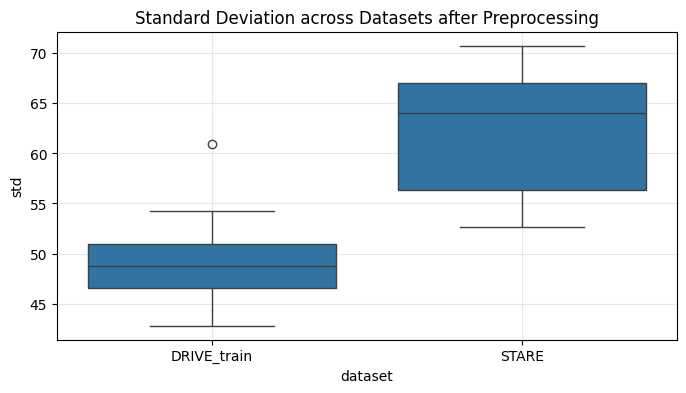

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.boxplot(data=df_all, x="dataset", y="std")
plt.title("Standard Deviation across Datasets after Preprocessing")
plt.grid(True, alpha=0.3)
plt.show()

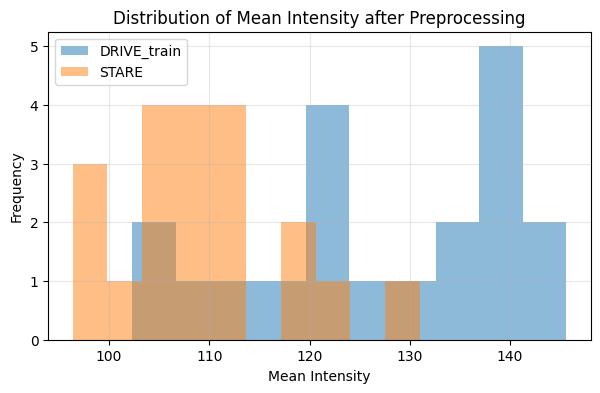

In [ ]:
plt.figure(figsize=(7,4))
for name, df in [("DRIVE_train", drive_train_stats), ("STARE", stare_stats)]:
    plt.hist(df["mean"], bins=10, alpha=0.5, label=name)
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Intensity after Preprocessing")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

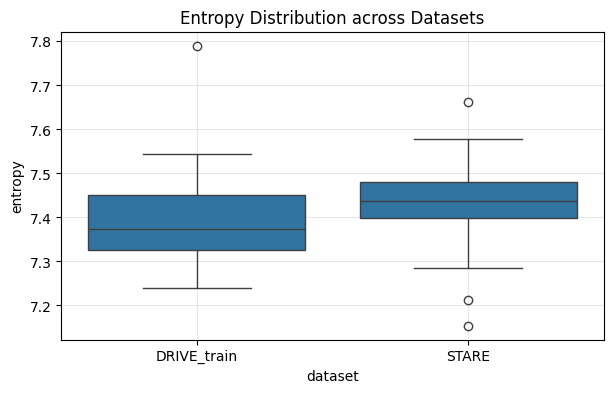

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(data=pd.concat([drive_train_stats, stare_stats]), x="dataset", y="entropy")
plt.title("Entropy Distribution across Datasets")
plt.grid(True, alpha=0.3)
plt.show()

##### Đánh giá ảnh sau tiền xử lý và trước tiền xử lý

Kiểm tra xem tiền xử lý có thực sự cải thiện độ sáng, tương phản và chi tiết của ảnh

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy
import glob
from tqdm import tqdm
import os
import cv2
import numpy as np
import pandas as pd

def analyze_before_preproc(img_dir, mask_dir, name, img_ext="tif", mask_suffix="_mask.gif"):
    """
    Phân tích dataset TRƯỚC tiền xử lý: RGB → Green-weighted grayscale
    Đo thống kê ảnh trước khi xử lý (ảnh chỉ chuyển về grayscale focus kênh G)
    """
    records = []
    imgs = sorted(glob.glob(f"{img_dir}/*.{img_ext}"))

    for path in tqdm(imgs, desc=f"Processing {name} (Before preprocessing)"):
        base = os.path.basename(path)
        img = cv2.imread(path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = rgb2gray_single(img_rgb)

        # tìm mask tương ứng
        mask_name = base.replace(".tif", mask_suffix).replace(".png", mask_suffix)
        mask_path = os.path.join(mask_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.ones_like(gray) if mask is None else (mask > 0).astype(np.uint8)

        fov = gray[mask > 0]
        records.append({
            "dataset": name + "_before",
            "image": base,
            "mean": np.mean(fov),
            "std": np.std(fov),
            "entropy": shannon_entropy(fov)
        })
    return pd.DataFrame(records)

# Phân tích TRƯỚC tiền xử lý
drive_before = analyze_before_preproc(drive_train_img_dir, drive_train_mask_dir, "DRIVE_train")
stare_before = analyze_before_preproc(stare_img_dir, stare_img_dir, "STARE", img_ext="png", mask_suffix=".png")

# Gộp dữ liệu
drive_combined = pd.concat([drive_before, drive_train_stats], ignore_index=True)
stare_combined = pd.concat([stare_before, stare_stats], ignore_index=True)

# Thêm cột trạng thái
drive_combined["status"] = drive_combined["dataset"].apply(lambda x: "Before" if "before" in x else "After")
drive_combined["dataset"] = "DRIVE"
stare_combined["status"] = stare_combined["dataset"].apply(lambda x: "Before" if "before" in x else "After")
stare_combined["dataset"] = "STARE"

Processing STARE (Before preprocessing): 100%|██████████| 20/20 [00:01<00:00, 14.72it/s]


In [ ]:
drive_combined.groupby("status")[["mean","std","entropy"]].describe()

mean                                                             \
       count        mean        std         min         25%         50%   
status                                                                    
After   20.0  127.098678  13.353061  102.318878  119.539704  128.047868   
Before  20.0   86.856458  18.313479   51.825230   77.774921   86.787018   

                                 std             ...                        \
               75%         max count       mean  ...        75%        max   
status                                           ...                         
After   138.379731  145.573285  20.0  48.824162  ...  50.913341  60.920776   
Before  102.333803  113.831530  20.0  17.658851  ...  19.019999  36.201184   

       entropy                                                              \
         count      mean       std       min       25%       50%       75%   
status                                                                       
After     20.0  7.397749  0.123560  7.239467  7.325654  7.374298  7.451632   
Before    20.0  5.689097  0.492377  4.797926  5.440965  5.642698  5.853070   

                  
             max  
status            
After   7.790157  
Before  7.004213  

[2 rows x 24 columns]

In [ ]:
stare_combined.groupby("status")[["mean","std","entropy"]].describe()

mean                                                            \
       count        mean        std        min         25%         50%   
status                                                                   
After   20.0  109.524181   8.643304  96.393546  104.875975  108.211656   
Before  20.0   70.701514  13.296618  54.503274   62.483825   68.945851   

                                 std             ...                        \
               75%         max count       mean  ...        75%        max   
status                                           ...                         
After   112.243201  130.974335  20.0  62.001135  ...  66.991907  70.726723   
Before   79.892920  102.324614  20.0  36.407443  ...  41.123634  63.343147   

       entropy                                                              \
         count      mean       std       min       25%       50%       75%   
status                                                                       
After     20.0  7.423386  0.115532  7.154382  7.398543  7.438026  7.479286   
Before    20.0  6.516895  0.363140  5.989914  6.329914  6.438475  6.735878   

                  
             max  
status            
After   7.661118  
Before  7.570293  

[2 rows x 24 columns]

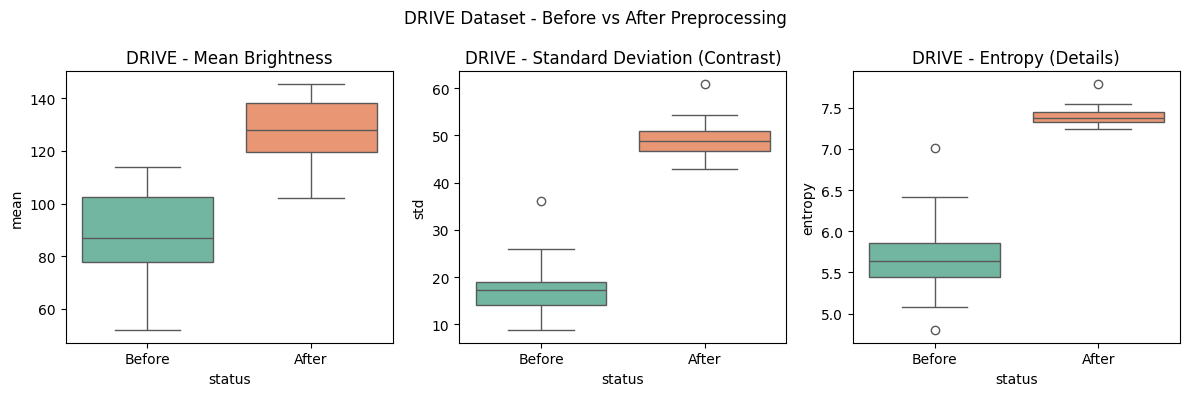

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.boxplot(data=drive_combined, x="status", y="mean", ax=axes[0], palette="Set2", hue = "status", legend = False)
axes[0].set_title("DRIVE - Mean Brightness")

sns.boxplot(data=drive_combined, x="status", y="std", ax=axes[1], palette="Set2", hue = "status", legend = False)
axes[1].set_title("DRIVE - Standard Deviation (Contrast)")

sns.boxplot(data=drive_combined, x="status", y="entropy", ax=axes[2], palette="Set2", hue = "status", legend = False)
axes[2].set_title("DRIVE - Entropy (Details)")

plt.suptitle("DRIVE Dataset - Before vs After Preprocessing")
plt.tight_layout()
plt.show()

Sau xử lý, độ sáng và tương phản tăng, entropy cũng tăng -> pipeline cải thiện chất lượng đầu vào. Cần xem xét kỹ thuật data augmentation: andom brightness, gamma correction, elastic deformation để mô hình học được sự đa dạng tự nhiên của các điều kiện chụp khác nhau.

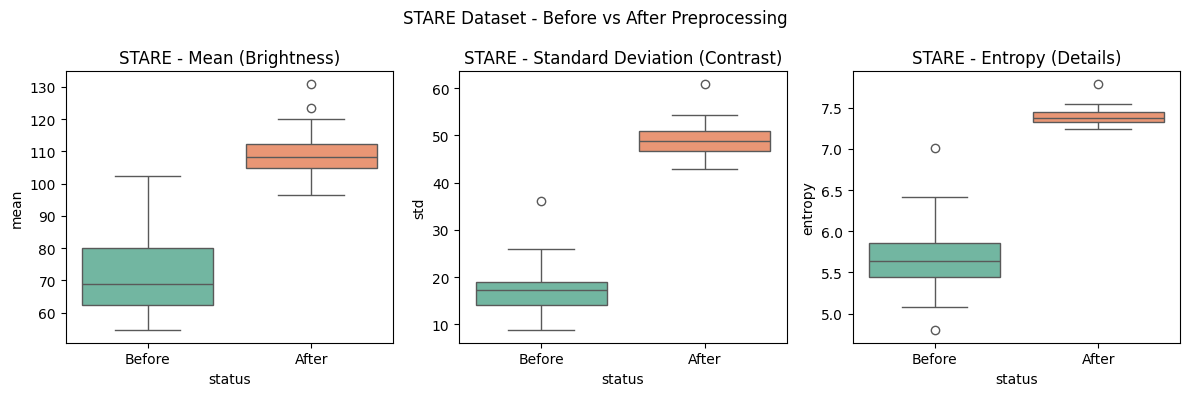

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.boxplot(data=stare_combined, x="status", y="mean", ax=axes[0], palette="Set2", hue = "status", legend = False)
axes[0].set_title("STARE - Mean (Brightness)")

sns.boxplot(data=drive_combined, x="status", y="std", ax=axes[1], palette="Set2", hue = "status", legend = False)
axes[1].set_title("STARE - Standard Deviation (Contrast)")

sns.boxplot(data=drive_combined, x="status", y="entropy", ax=axes[2], palette="Set2", hue = "status", legend = False)
axes[2].set_title("STARE - Entropy (Details)")

plt.suptitle("STARE Dataset - Before vs After Preprocessing")
plt.tight_layout()
plt.show()

Tiền xử lý giúp tăng độ sáng, cải thiện tương phảm và làm rõ chi tiết mạch máu. Nó vẫn tối và kém chi tiết hơn DRIVE tương tự như nhận xét trên. Do vậy, data augmentation có thể tập trung vào brightness và contrast.